# Predict Goals from Parameters

Using the samples I generated, I want to see if I can predict clinical goals based on the dose parameters.
I'll try using Gaussian processes, so I first need to see what kernels work best.
I think it'd be cool to have an interactive dashboard where you can modify the parameters and see an updated estimate for the clinical goals.
It'd be even better to have a prediction of the dose-volume histograms, but that'd be a lot more expensive, since you'd have to predict hundreds of values rather than just one.

For now, I'll look into the relationships between the goals and parameters, and see how best to create a function to estimate goal values.
Since I saw a piecewise-linear relationship, I'm wondering if I can get good results using regression rather than the Gaussian Process.
I could try both and compare which does a better job.

Next I'd have to think about how to do this when you have multiple patients. 
The advantage of using a Gaussian Process is that you have some range of values estimated, with some associated probability, rather than just one value returned.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set(color_codes=True, font_scale=1.2)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process import kernels
import utils

In [2]:
# Smaller parameter ranges
samples0 = np.load('samples_6_5.npy', allow_pickle=True)

# Larger parameter ranges
samples_full = np.load('samples_6_8.npy', allow_pickle=True)
samples1 = []
for sample in samples_full:
    if len(sample) == 3:
        samples1.append(sample)

In [119]:
oar_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs']
roi_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs', 'PTV']
par_list0 = {oar: utils.roi_pars(samples0, oar)[0] for oar in oar_list}
par_list0['Rib'] = par_list0['Rib'][:100]
par_list1 = {oar: utils.roi_pars(samples1, oar)[0] for oar in oar_list}

# Which parameters are most important for each goal?

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


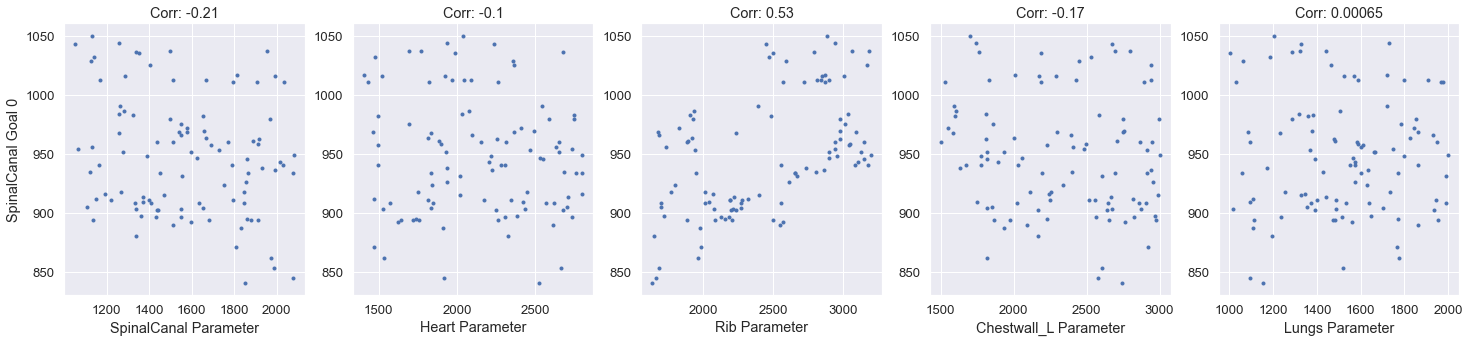

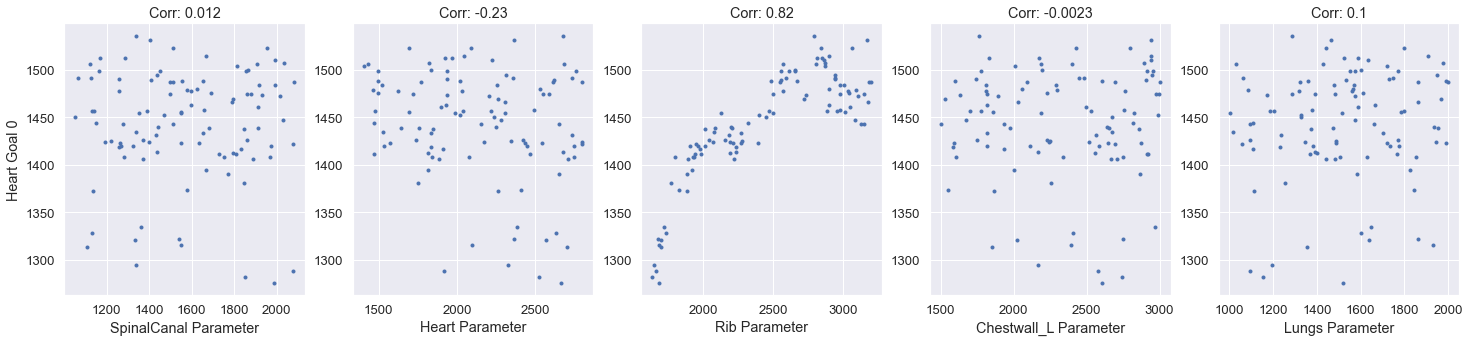

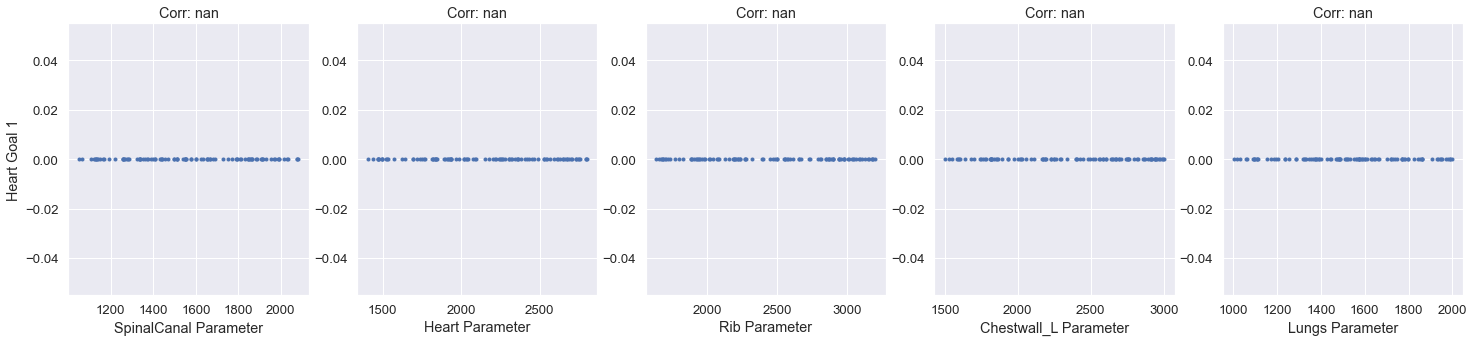

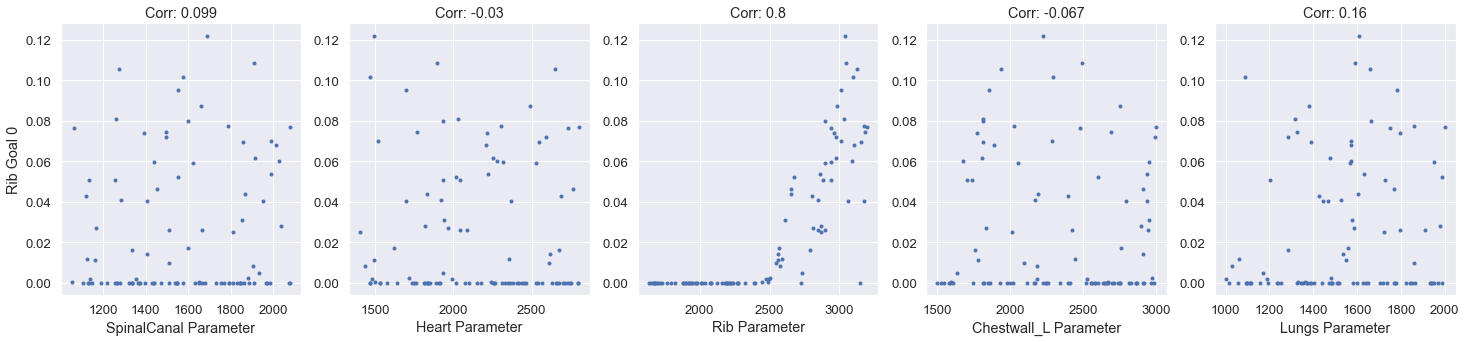

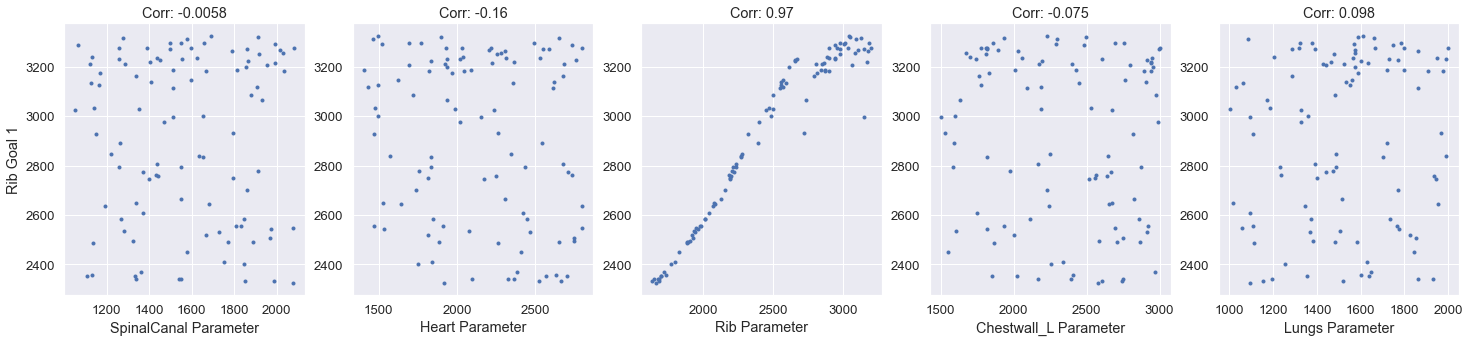

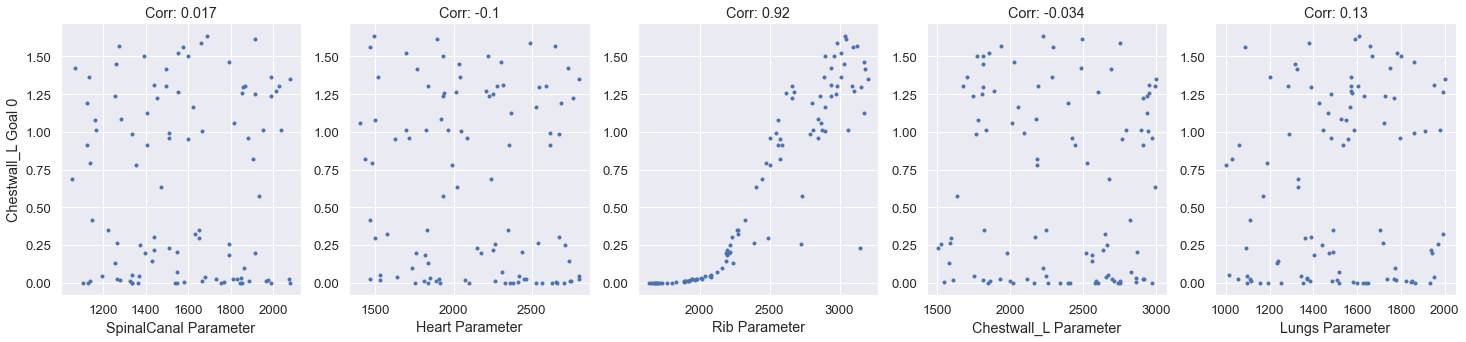

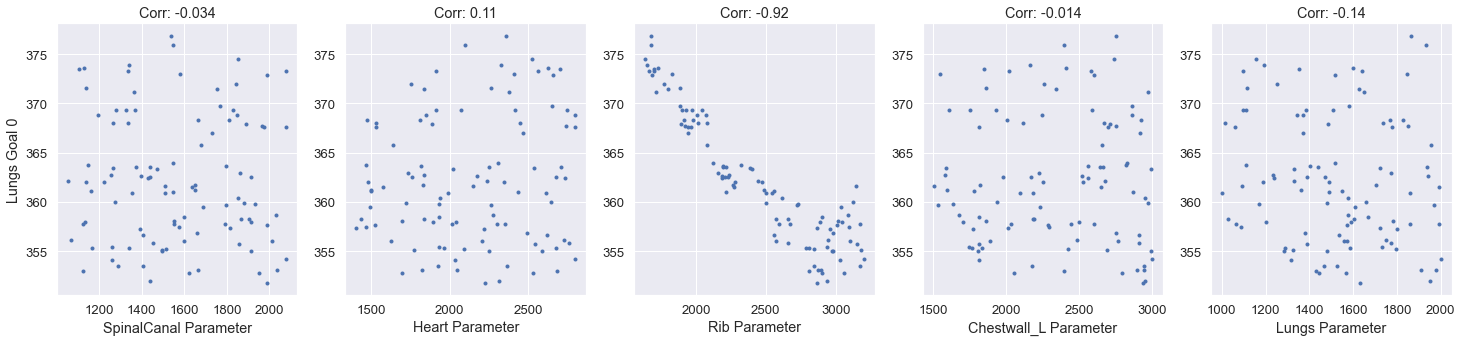

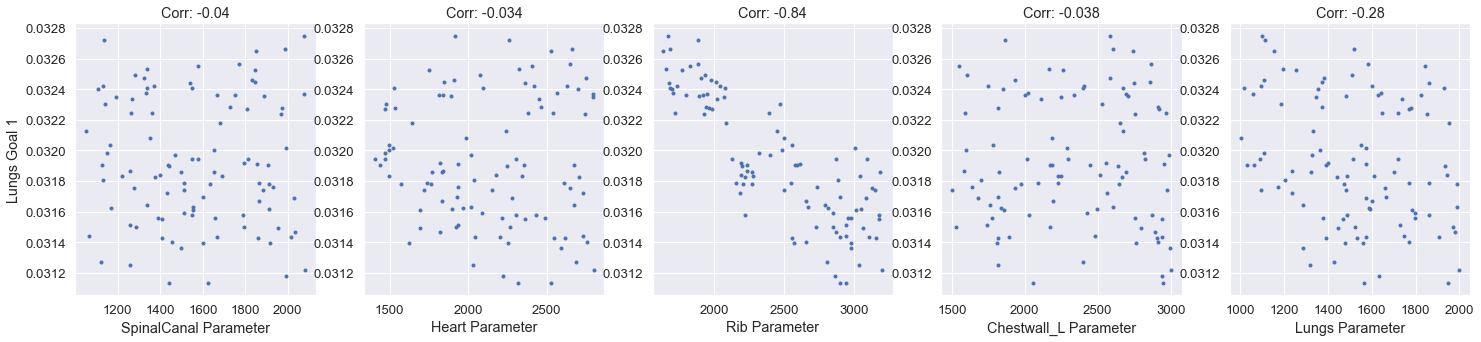

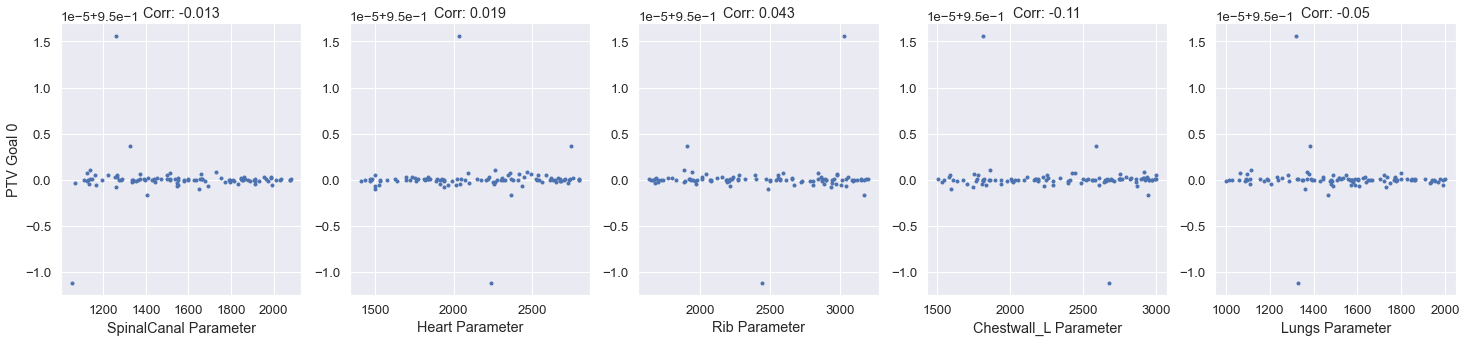

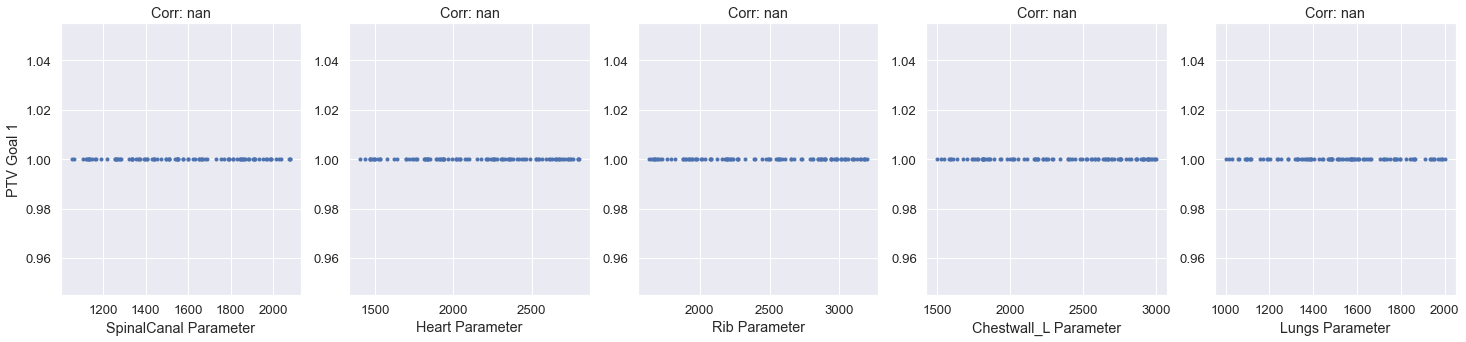

In [122]:
# Smaller parameter range
for roi in roi_list:
    goal_list = utils.roi_goals(samples0, roi, percent=False)
    for ii in range(len(goal_list)):
        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        for jj in range(len(oar_list)):
            x = par_list0[oar_list[jj]]
            y = goal_list[ii]
            ax[jj].plot(x, y, '.')
            ax[jj].set_xlabel(f'{oar_list[jj]} Parameter')
            ax[jj].set_title(f'Corr: {np.corrcoef(x, y)[0, 1]:.2}')
        ax[0].set_ylabel(f'{roi} Goal {ii}')
        
# Relationships:
# * SpinalCanal Goal 0 and Rib (0.53)
# * Heart Goal 0 and Rib (0.82)
# * Rib Goal 0 and Rib (0.8)
# * Rib Goal 1 and Rib (0.97)
# * Chestwall_L Goal 0 and Rib (0.92)
# * Lungs Goal 0 and Rib (-0.92)
# * Lungs Goal 1 and Rib (-0.84)

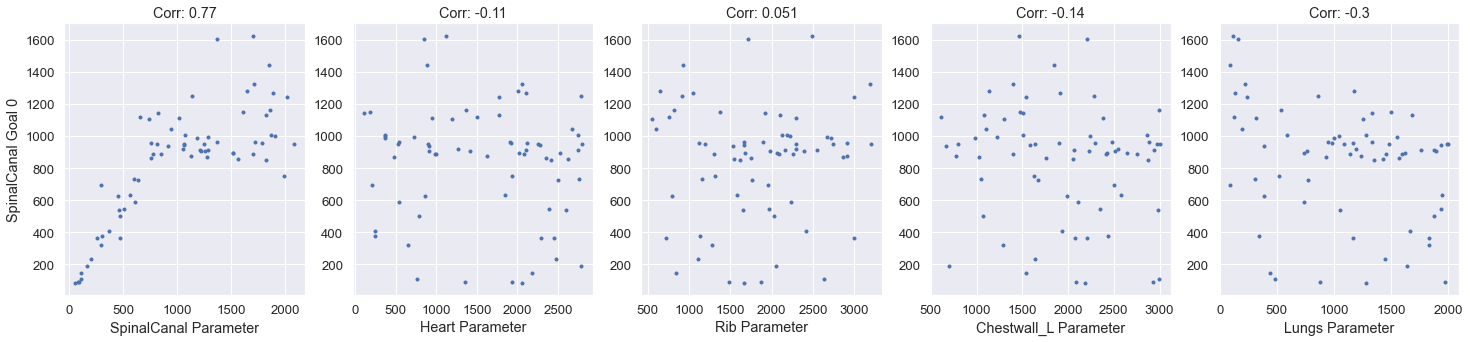

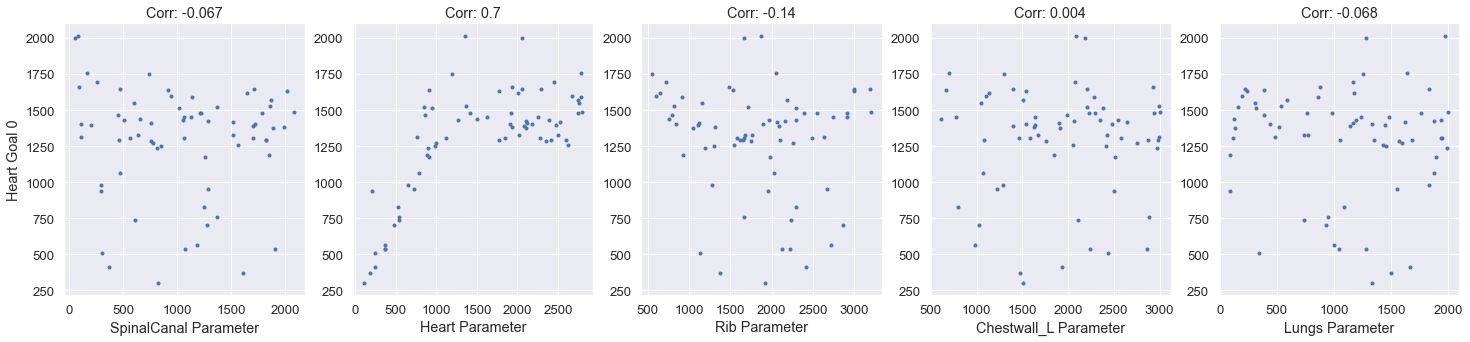

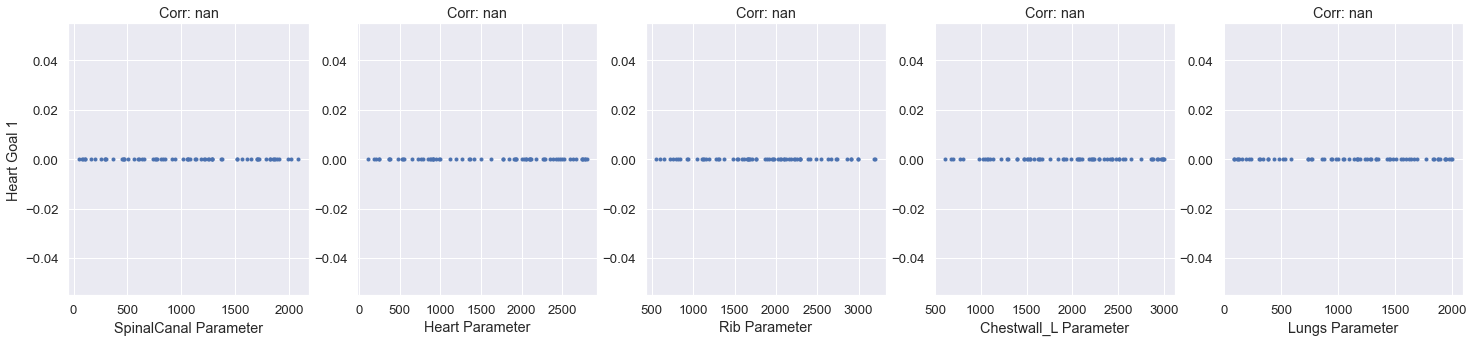

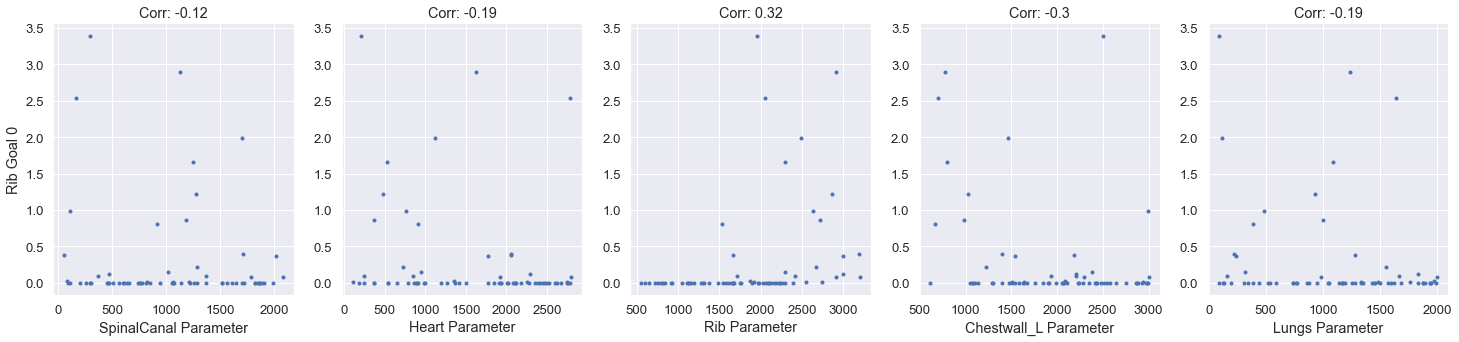

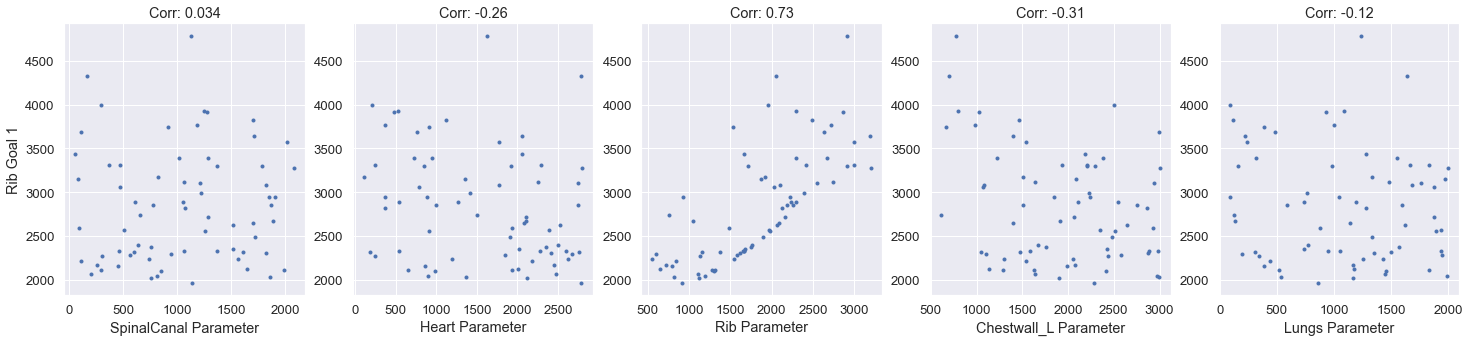

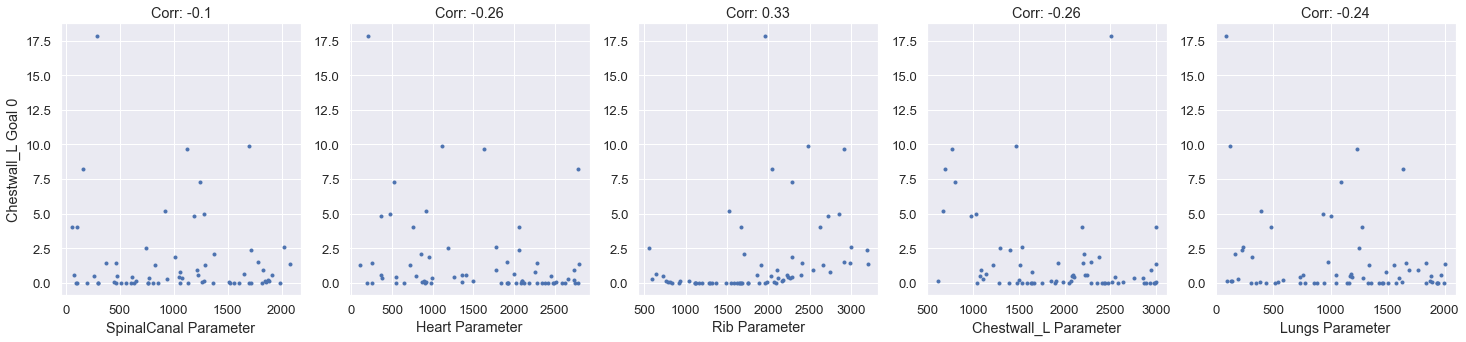

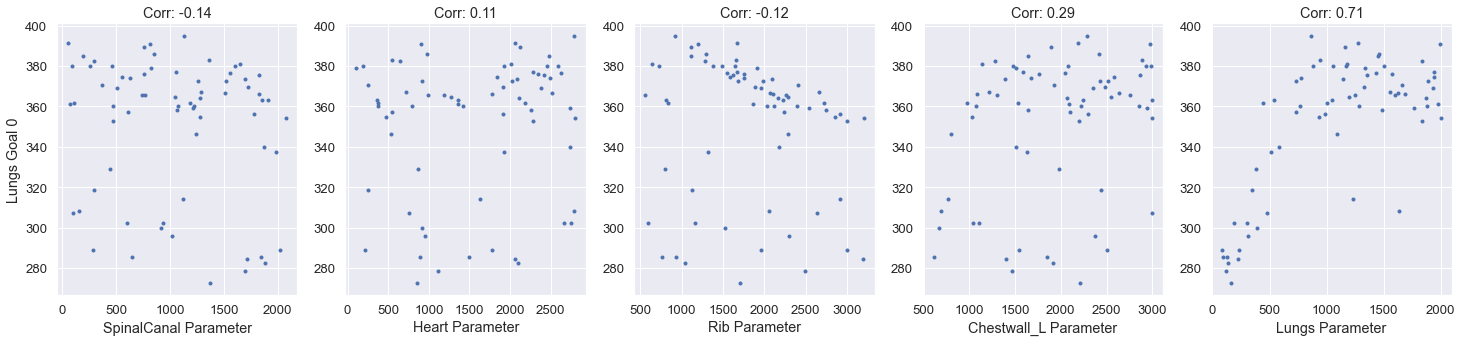

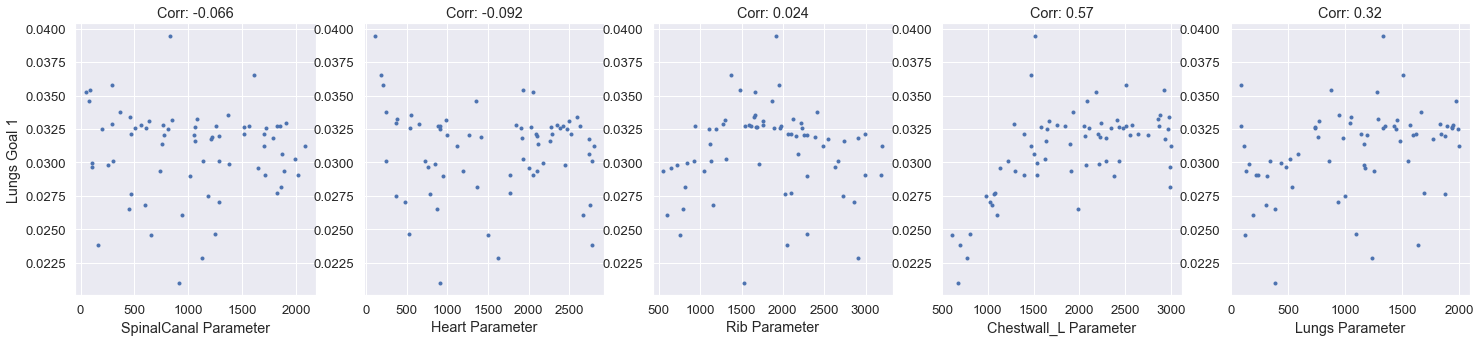

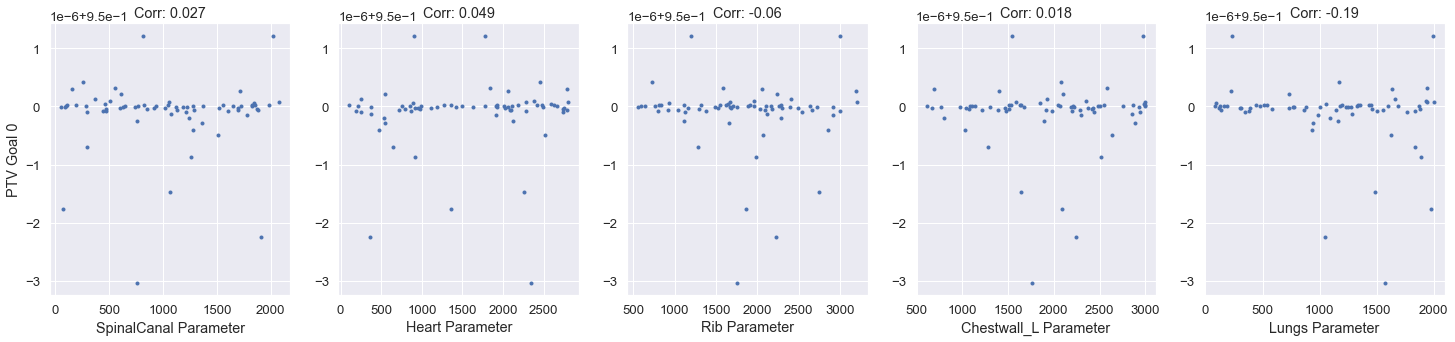

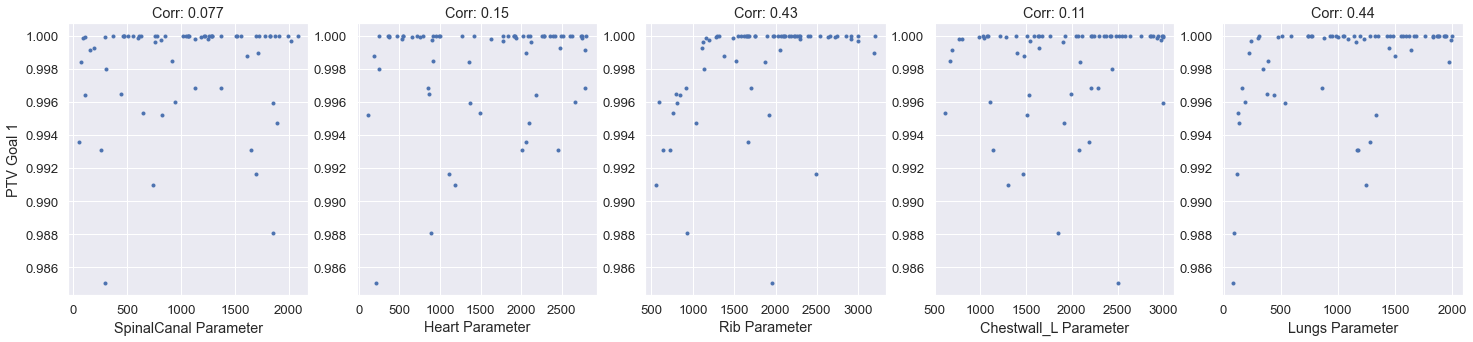

In [123]:
# Larger parameter range
for roi in roi_list:
    goal_list = utils.roi_goals(samples1, roi, percent=False)
    for ii in range(len(goal_list)):
        fig, ax = plt.subplots(1, 5, figsize=(25, 5))
        for jj in range(len(oar_list)):
            x = par_list1[oar_list[jj]]
            y = goal_list[ii]
            ax[jj].plot(x, y, '.')
            ax[jj].set_xlabel(f'{oar_list[jj]} Parameter')
            ax[jj].set_title(f'Corr: {np.corrcoef(x, y)[0, 1]:.2}')
        ax[0].set_ylabel(f'{roi} Goal {ii}')
        
# Relationships:
# * SpinalCanal Goal 0 and SpinalCanal (0.77) (est. 0-1000)
# * Heart Goal 0 and Heart (0.7) (est. 0-1000)
# * Rib Goal 1 and Rib (0.73) (est. 1000-2500)
# * Lungs Goal 0 and Rib (-0.12) (est. 1000-3000)
# * Lungs Goal 0 and Lungs (0.71) (est. 0-1000)
# * Lungs Goal 1 and Chestwall_L (0.57) (est. 500-1500)

In [128]:
def goal_v_par(roi, oar, goal, alpha):
    # Get goal values
    goal0 = utils.roi_goals(samples0, roi, percent=False)[goal]
    goal1 = utils.roi_goals(samples1, roi, percent=False)[goal]
    
    # Plot both datasets
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].plot(par_list0[oar], goal0, '.')
    ax[0].plot(par_list1[oar], goal1, '.')
    ax[0].set_xlabel(f'{oar} Parameter')
    ax[0].set_ylabel(f'{roi} Goal {goal}')
    ax[0].set_title('Both Datasets')
    plot_estimates(par_list0[oar] + par_list1[oar], goal0 + goal1, alpha[0], ax[0])
    
    # Plot large dataset
    ax[1].plot(par_list1[oar], goal1, '.')
    ax[1].set_xlabel(f'{oar} Parameter')
    ax[1].set_title('Large Dataset')
    plot_estimates(par_list1[oar], goal1, alpha[1], ax[1])
    
    # Plot small dataset
    ax[2].plot(par_list0[oar], goal0, '.')
    ax[2].set_xlabel(f'{oar} Parameter')
    ax[2].set_title('Small Dataset')
    plot_estimates(par_list0[oar], goal0, alpha[2], ax[2])

In [155]:
def plot_estimates(x_vals, y_vals, alpha, ax):
    gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=alpha)\
                                   .fit(np.array(x_vals).reshape(-1, 1),\
                                        (y_vals - np.mean(y_vals))/np.std(y_vals))
    x = np.linspace(min(x_vals), max(x_vals), 100)
    y, std = gpr.predict(x.reshape(-1, 1), return_std=True)
    y = y*np.std(y_vals) + np.mean(y_vals)
    std *= np.std(y_vals)
    ax.plot(x, y)
    ax.fill_between(x, y - std, y + std, color='darkorange', alpha=0.2)
    
# Not good at fitting endpoints
# Could lower alpha values for those points

# SpinalCanal Goal 0: At most 2080 cGy dose at 0.35 cm$^3$  volume

Closer look:
* Small: SpinalCanal Goal 0 and Rib (0.53)
* Large: SpinalCanal Goal 0 and SpinalCanal (0.77) (est. 0-1000)

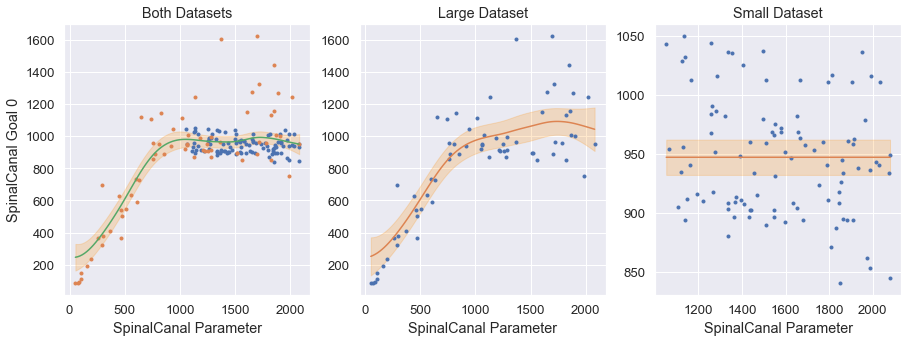

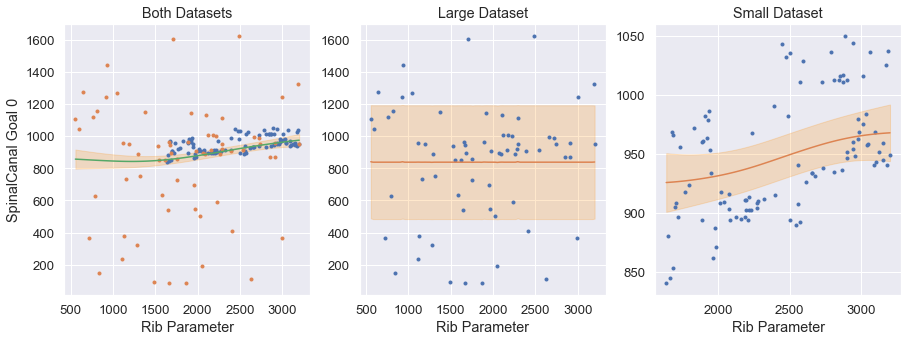

In [157]:
goal_v_par('SpinalCanal', 'SpinalCanal', 0, [1e0, 1e0, 1e1])
goal_v_par('SpinalCanal', 'Rib', 0, [1e0, 1e2, 1e1])

# Heart Goal 0: At most 3400 cGy dose at 0 cm$^3$  volume

Closer look:
* Small: Heart Goal 0 and Rib (0.82)
* Large: Heart Goal 0 and Heart (0.7) (est. 0-1000)

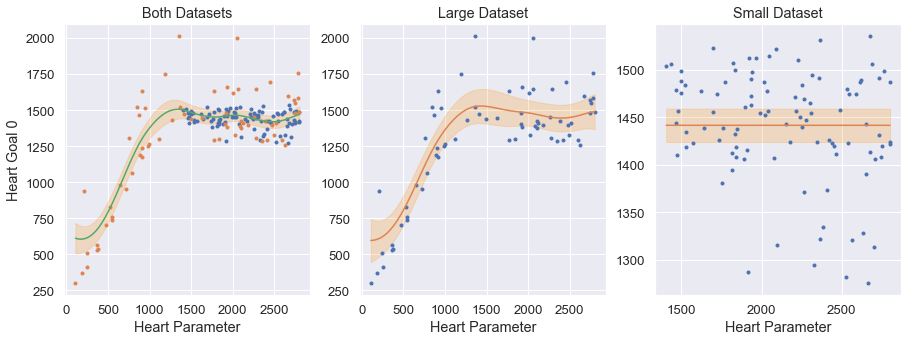

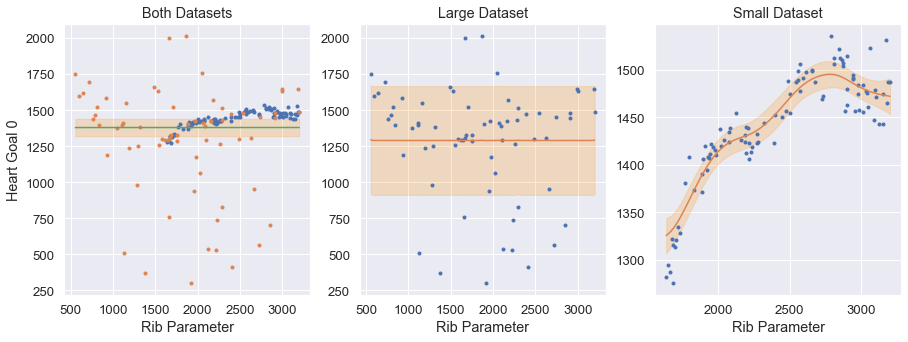

In [188]:
goal_v_par('Heart', 'Heart', 0, [1e0, 1e0, 1e1])
goal_v_par('Heart', 'Rib', 0, [1e1, 1e2, 1e0])

# Rib Goal 0: At most 1 cm$^3$  volume at 3200 cGy dose

Closer look:
* Small: Rib Goal 0 and Rib (0.8)

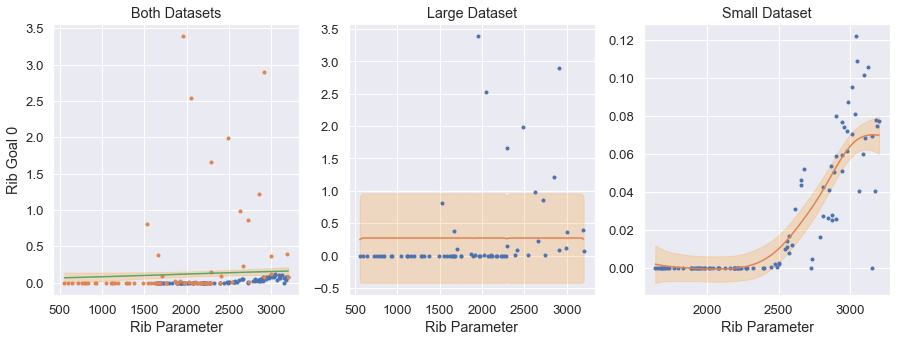

In [200]:
goal_v_par('Rib', 'Rib', 0, [1e0, 1e1, 1e0])

# Rib Goal 1: At most 4000 cGy dose at 0.04 cm$^3$ volume	

Closer look:
* Small: Rib Goal 1 and Rib (0.97)
* Large: Rib Goal 1 and Rib (0.73) (est. 1000-2500)

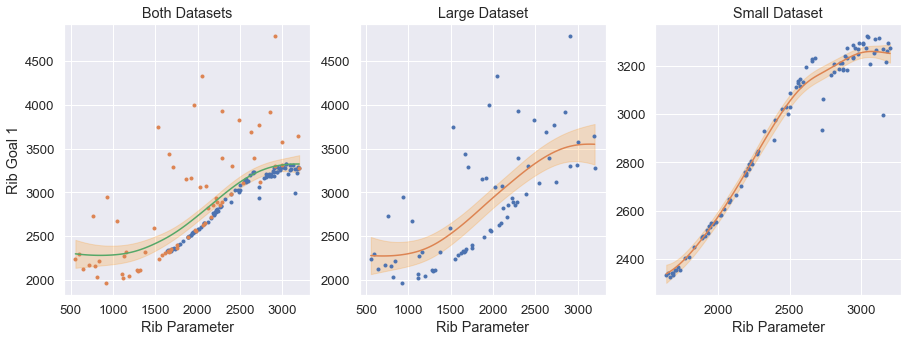

In [216]:
goal_v_par('Rib', 'Rib', 1, [1e0, 1e0, 1e-1])

# Chestwall_L Goal 0: At most 30 cm$^3$ volume at 3000 cGy dose

Closer look:
* Small: Chestwall_L Goal 0 and Rib (0.92)

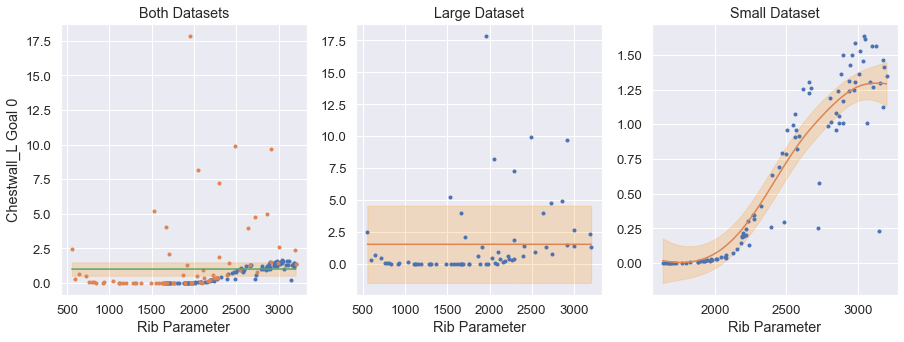

In [228]:
goal_v_par('Chestwall_L', 'Rib', 0, [1e1, 1e2, 1e0])

# Lungs Goal 0: At most 1500 cm$^3$ volume at 1160 cGy dose

Closer look:
* Small: Lungs Goal 0 and Rib (-0.92)
* Large: Lungs Goal 0 and Lungs (0.71) (est. 0-1000)
* Large: Lungs Goal 0 and Rib (-0.12) (est. 1000-3000)

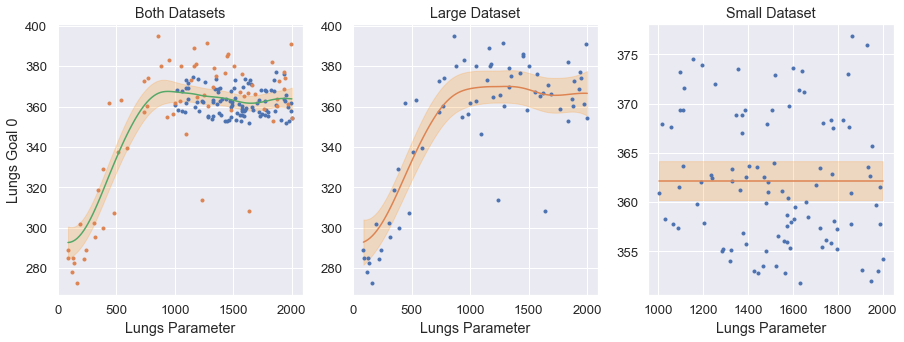

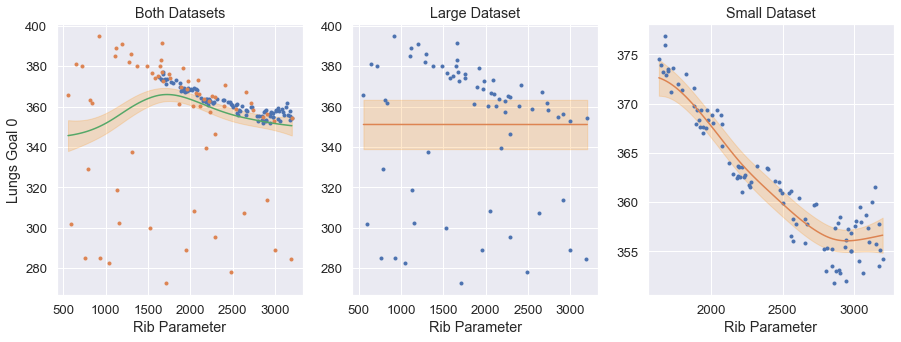

In [245]:
goal_v_par('Lungs', 'Lungs', 0, [1e0, 1e0, 1e1])
goal_v_par('Lungs', 'Rib', 0, [1e0, 1e1, 1e0])

# Lungs Goal 1: At most 10 % volume at 2000 cGy dose

Closer look:
* Small: Lungs Goal 1 and Rib (-0.84)
* Large: Lungs Goal 1 and Chestwall_L (0.57) (est. 500-1500)

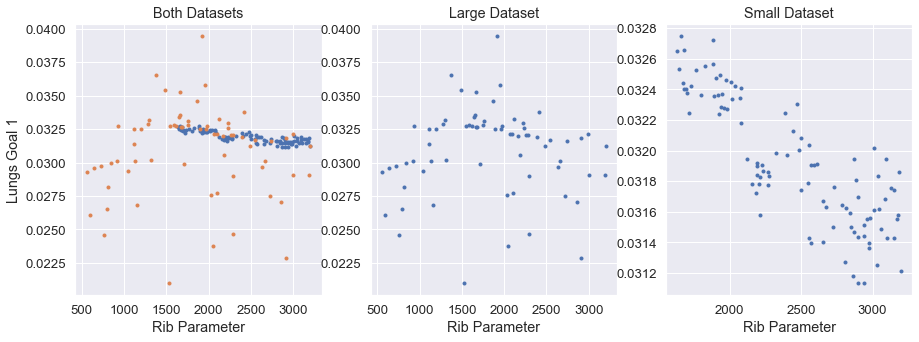

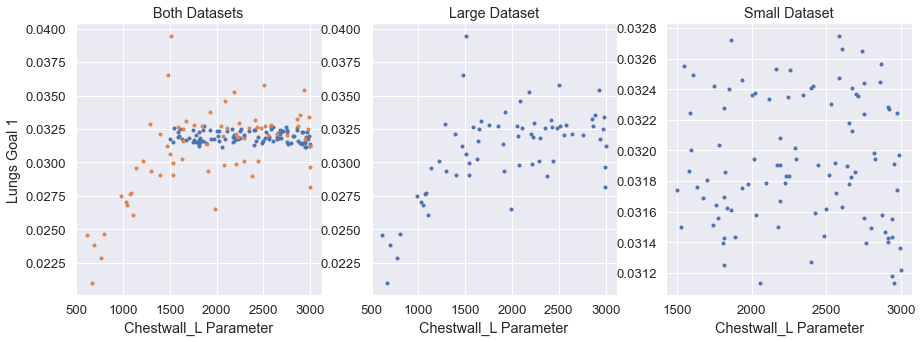

In [35]:
goal_v_par('Lungs', 'Rib', 1)
goal_v_par('Lungs', 'Chestwall_L', 1)

# Fit alpha kernel parameter

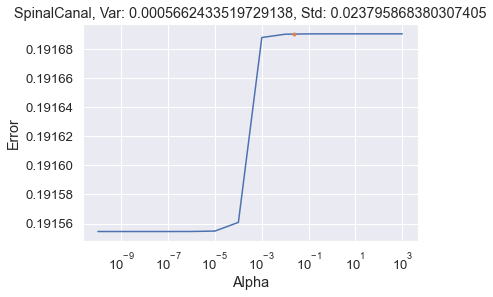

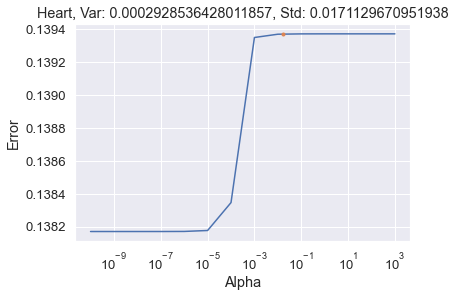

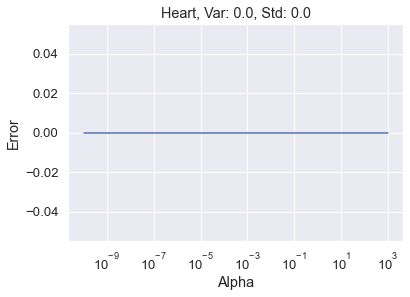

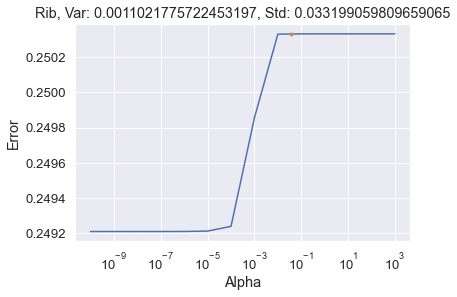

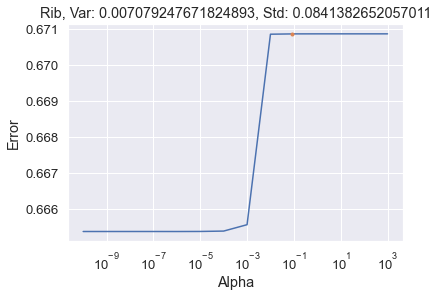

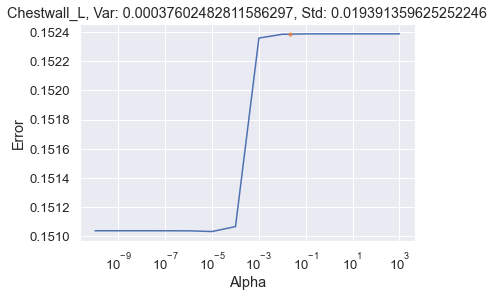

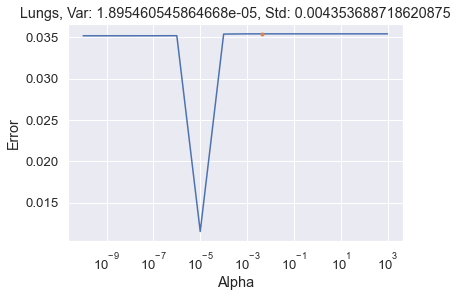

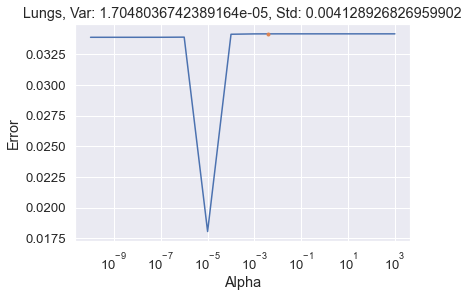

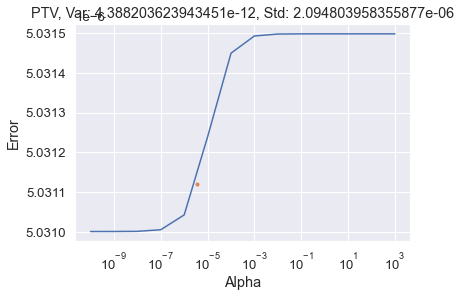

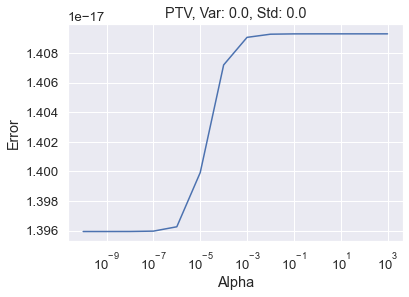

In [664]:
for roi in roi_list:
    goal_list = utils.roi_goals(samples, roi)
    for goal in goal_list:
        goal_vals = np.array(goal)
        goal_vals -= np.mean(goal_vals)
        par_vals = []
        for ii in range(len(oar_list)):
            par_vals.append(utils.roi_pars(samples, oar)[0])
        par_vals = np.array(par_vals).T

        a_vals = 10.0**np.arange(-10, 4)
        n_vals = []
        
        for alpha in a_vals:
            gpr = GaussianProcessRegressor(kernel=1.0*kernels.Matern(), alpha=alpha).fit(par_vals[0:34], goal_vals[0:34])
            y_mean = gpr.predict(par_vals[34:])
            n_vals.append(np.linalg.norm(y_mean - goal_vals[34:]))
            
        gpr = GaussianProcessRegressor(kernel=1.0*kernels.Matern(),
                                       alpha=np.std(goal_vals[0:34])).fit(par_vals[0:34], goal_vals[0:34])
        y = gpr.predict(par_vals[34:])
        n = np.linalg.norm(y - goal_vals[34:])
        
        plt.figure()
        plt.semilogx(a_vals, n_vals)
        plt.semilogx(np.std(goal_vals[0:34]), n, '.')
        plt.xlabel('Alpha')
        plt.ylabel('Error')
        plt.title(f'{roi}, Var: {np.var(goal_vals)}, Std: {np.std(goal_vals)}')
    
# Using all the data
# SpinalCanal: 1e-3
# Heart: 1e-3, N/A
# Rib: 1e-2, 1e-3
# Chestwall_L: 1e-4
# Lungs: 1e-5, 1e-5
# PTV: 1e-4, 1e-7

# Using first half to train, second half to test
# SpinalCanal: 1e-1
# Heart: 1e-1, N/A
# Rib: 1e-1, 1e-1
# Chestwall_L: 1e-6
# Lungs: 1e-4, 1e-4
# PTV: 1e-5, 1e-5

# Using second half to train, first half to test
# SpinalCanal: 1e-1 std
# Heart: 1e-1, N/A std
# Rib: 1e-2, 1e-2 std
# Chestwall_L: 1e-3
# Lungs: 1e-3, 1e-4
# PTV: 1e-7, 1e-6

In [307]:
def plot1(roi, term, alpha=None):
    roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term]);
    for oar in oar_list:
        plot2(np.array(par_list[oar]), np.array(roi_list), oar, roi, alpha)
        
def plot2(par_list, roi_list, oar, roi, alpha):
    # Plot data
    plt.figure()
    plt.plot(par_list, roi_list - np.mean(roi_list), '.')
    
#     # Estimate function
#     x = par_list.reshape(-1, 1)
#     y = roi_list - np.mean(roi_list)
#     gpr = GaussianProcessRegressor(kernel=1.0*kernels.Matern(), alpha=alpha).fit(x, y)
    
#     # Estimate values
#     x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
#     y_mean, y_std =gpr.predict(x_vals, return_std=True)
    
#     # Plot values
#     plt.plot(x_vals, y_mean)
#     plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)
    
    # Add labels
    plt.xlabel(f'{oar} Parameter Value')
    plt.ylabel(f'{roi} Goal Value')
    plt.title(f'Corr: {np.corrcoef(par_list, roi_list)[0, 1]}, Std: {np.std(y)}')

In [219]:
# What are the ranges for which parameters have an effect?
# How do you set the alpha value? (cross-validation?)


Let's ignore the parameter ranges, and just see if we can do a multi-dimensional guy, and look at alpha values

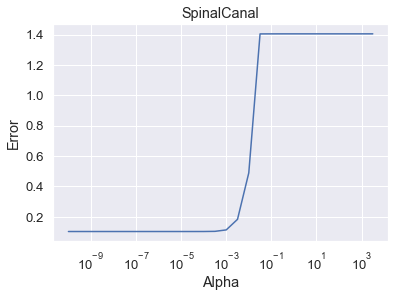

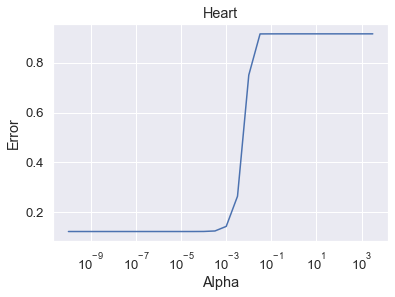

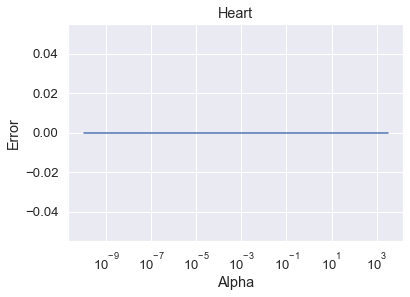

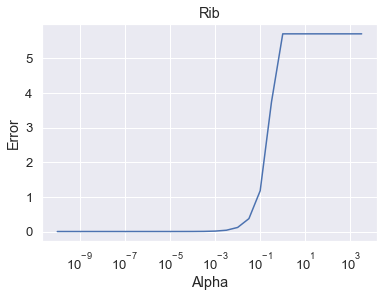

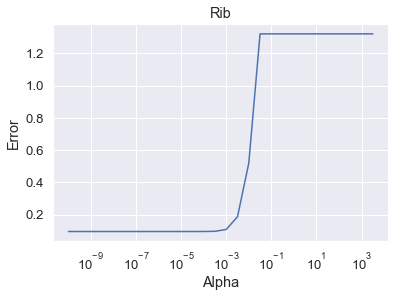

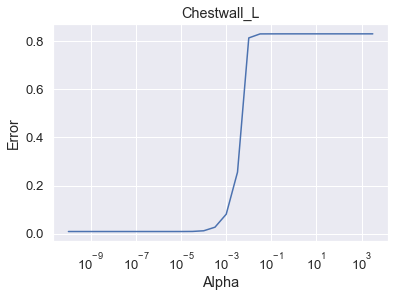

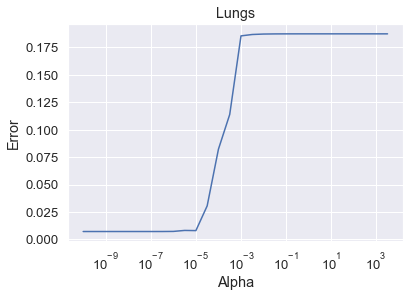

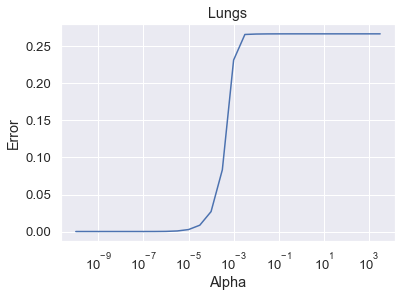

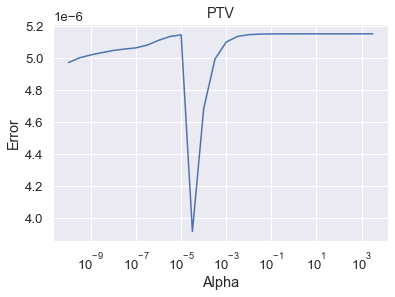

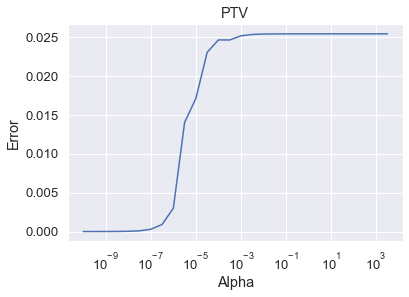

In [ ]:
# now that I've got something working, I need to fit it with train, cross validate, and test
# maybe 80 10 10?
# or just 80/20 using values I find

# ooh, just thought of something: of course it will look good on the ones that I've fit...
# because that's how a Gaussian process works
# but what about when I split things?

In [390]:
par_train

array([[ 741, 1190,  556, 1298, 1250],
       [1698, 1117, 2485, 1468,  116],
       [ 651, 1497,  760,  610,  126],
       [ 259, 2452,  722, 2076, 1167],
       [ 559, 1841, 1584, 2578, 1943],
       [2017, 1775, 2998, 1538,  237],
       [1720, 1909, 1892, 2478, 1329],
       [1886, 2102, 1042, 1910,  134],
       [1559, 2628, 1545, 2048, 1428],
       [1258,  914, 1979, 2515, 1889],
       [  76, 1357, 1867, 2087, 1971],
       [ 600, 2754, 1158, 1044,  305],
       [1015,  949, 2292, 2377,  313],
       [ 446,  868,  793, 1985,  383],
       [ 462, 2595, 1648, 2985, 1052],
       [ 916,  912, 1527,  669,  388],
       [  90, 1931, 1486, 2929,  880],
       [1856, 1364,  814, 2994,  538],
       [1062, 2258, 2740, 1640, 1484],
       [1075,  375, 2120, 2858, 1284],
       [1822, 2418, 1618, 2869, 1352],
       [1283, 2105, 2163, 2064, 1872],
       [1367,  547, 1660, 2886,  946],
       [1050, 1267, 2287, 2550, 1192],
       [1649, 2006,  645, 1135, 1177],
       [1607,  185, 1373,

In [714]:
par_test

array([[1794, 1818, 2192, 2557, 1402],
       [1912, 1895, 3047, 2495, 1590],
       [1599, 1624, 2570, 2763, 1559],
       [1858, 2546, 3153, 1815, 1391],
       [1275, 2648, 3126, 1935, 1659],
       [1338, 2327, 1650, 2164, 1194],
       [1258, 1935, 2940, 1742, 1729],
       [1336, 1529, 2077, 2672, 1016],
       [1932, 1935, 2731, 1635, 1172],
       [1990, 2224, 2863, 2938, 1633],
       [1953, 1696, 3062, 2795, 1444],
       [1281, 2074, 1932, 1607, 1508],
       [1666, 1812, 1917, 2002, 1825],
       [1973, 1531, 1963, 1814, 1777],
       [1906, 1435, 2573, 2186, 1029],
       [1338, 2676, 2789, 1763, 1287],
       [1373, 2709, 2216, 2665, 1441],
       [1680, 1640, 2080, 2653, 1953],
       [1851, 2526, 1635, 2741, 1156],
       [1256, 1837, 2236, 1582, 1234]])

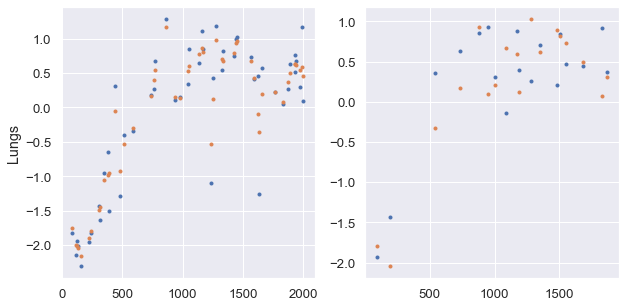

In [761]:
# This part is frustrating...

# Why does it always predict zero???

#oar_list = ['SpinalCanal', 'Heart', 'Rib', 'Chestwall_L', 'Lungs']
oar_list = ['Lungs']
par_list = {oar: utils.roi_pars(samples, oar)[0] for oar in oar_list}

roi = 'Lungs'
goal_list = np.array(utils.roi_goals(samples, roi, percent=False)[0])
goal_list = (goal_list - np.mean(goal_list))/np.std(goal_list)
par_list2 = []
for ii in range(len(oar_list)):
    par_list2.append(utils.roi_pars(samples, oar_list[ii])[0])
par_list2 = np.array(par_list2).T

n_train = 50
goal_train = goal_list[0:n_train]
par_train = par_list2[0:n_train, :]

goal_test = goal_list[n_train:]
par_test = par_list2[n_train:, :]

#goal_test = goal_list
#par_test = par_list2


gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e-1).fit(par_train, goal_train)
y_train = gpr.predict(par_train)
y_test = gpr.predict(par_test) #, return_std=True)

for ii in range(len(oar_list)):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(par_train[:, ii], goal_train, '.')
    ax[0].plot(par_train[:, ii], y_train, '.')
    ax[0].set_ylabel(oar_list[ii])
    
    ax[1].plot(par_test[:, ii], goal_test, '.')
    #for jj in range(len(par_test)):
    #    ax[1].plot([par_test[jj, ii], par_test[jj, ii]], [y_test[jj]-std[jj], y_test[jj]+std[jj]],'y')
    ax[1].plot(par_test[:, ii], y_test, '.')
    
    
    
# why doesn't having more information improve things?
    
#     plt.figure()
#     plt.plot(par_list[oar], goal_list, '.')
#     plt.plot(par_list[oar], y_mean, '.')
#     plt.xlabel(f'{oar} Parameter Value')
#     plt.ylabel(f'{roi} Goal Value')

# The only thing it seems capable of doing is over-fitting :)  

# Problem of not enough points?

# Maybe if you assume Gaussian for a parameter that's not, it will mess up results

# Maybe it was the kernel that was wrong! If the points are all over the place for some values,
# then it won't make sense to use RBF or Matern
# Can you have a different kernel for a different dimention?

# I think the main thing is to figure out which are the correct features, then the correct kernel
# The problem is that including a feature with the wrong kernel will give worse results

# Maybe if I plotted on the actual scale, it would look different?
# No, it would still look the same...

In [322]:
par_list[oar]

TypeError: list indices must be integers or slices, not str

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


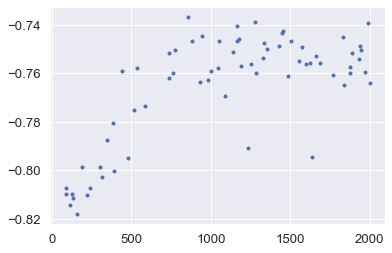

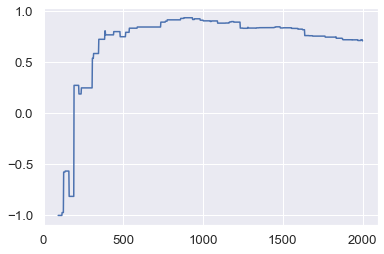

In [238]:
heart_par = np.array(utils.roi_pars(samples, 'Lungs')[0])
heart_goal = np.array(utils.roi_goals(samples, 'Lungs')[0])
plt.plot(heart_par, heart_goal, '.')

min_par = min(heart_par)
max_par = max(heart_par)
par_vals = np.linspace(min_par, max_par, 1000)
corr_vals = []
for ii in range(len(par_vals)):
    idx = heart_par <= par_vals[ii]
    corr_vals.append(np.corrcoef(heart_par[idx], heart_goal[idx])[1, 0])
plt.figure()
plt.plot(par_vals, corr_vals)

In [225]:
par_vals[-1]

2800.0

In [224]:
min_par

108

# Heart Goal 1

At most 3400 cGy dose at 0 cm$^3$ volume.

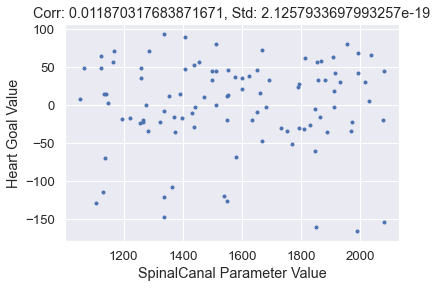

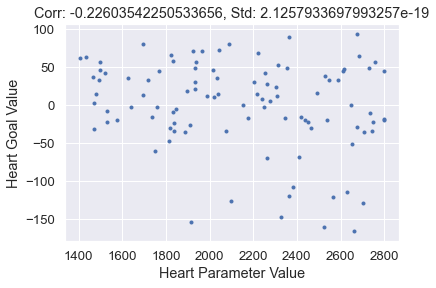

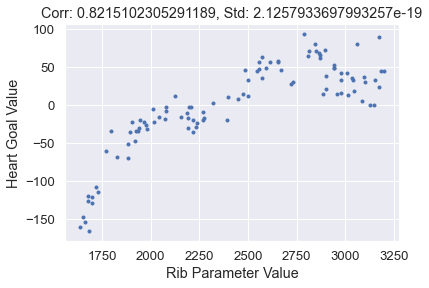

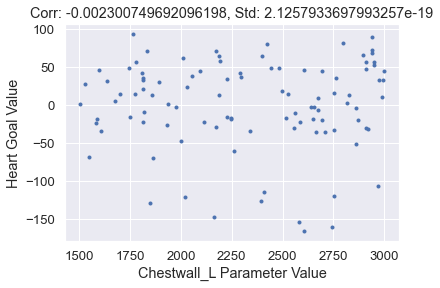

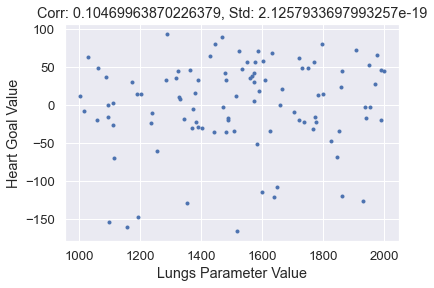

In [666]:
plot1('Heart', 0, 3e4) # 1e2 to 1e4

# Heart Goal 2

At most 15 cm$^3$ volume at 2800 cGy dose

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarni

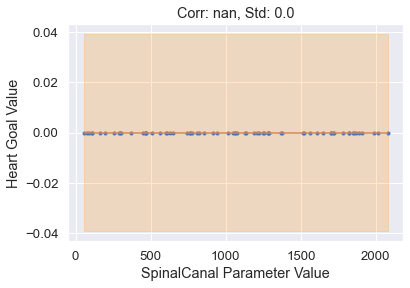

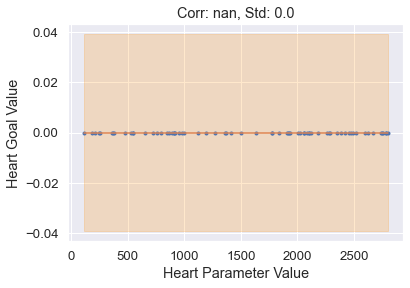

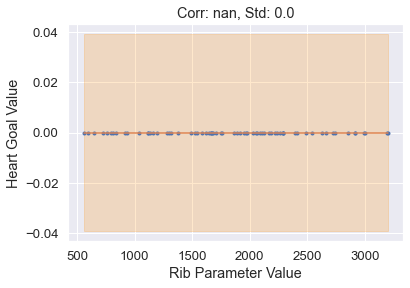

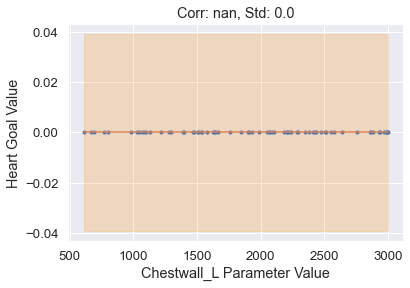

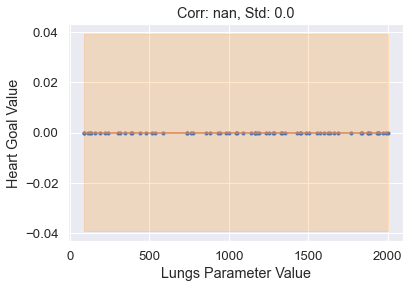

In [164]:
plot1('Heart', 1, 1e4)

# Lungs Goal 1

At most 1500 cm$^3$ volume at 1160 cGy dose

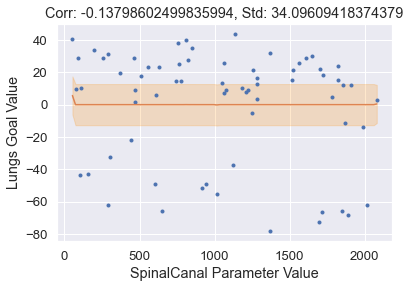

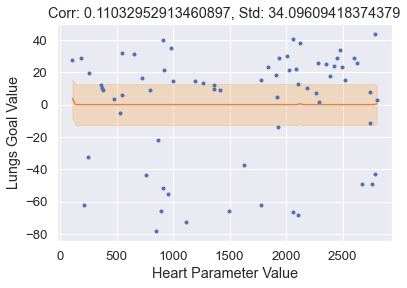

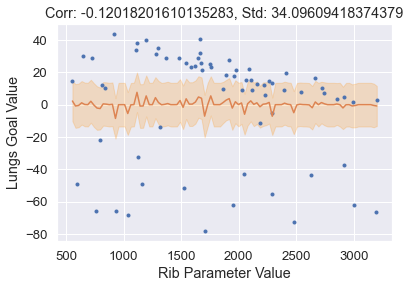

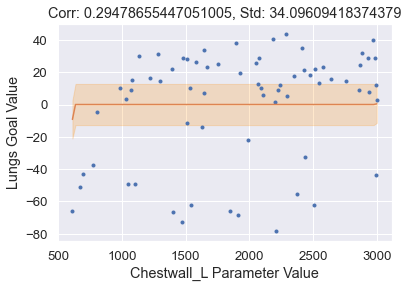

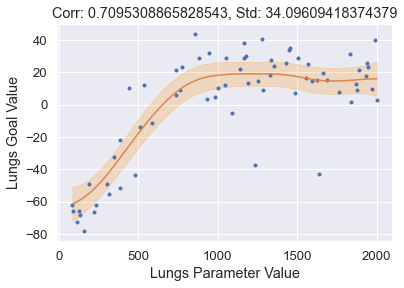

In [165]:
plot1('Lungs', 0, 1e3) # 1e2 to 1e3

# Lungs Goal 2

At most 10 % volume at 2000 cGy dose

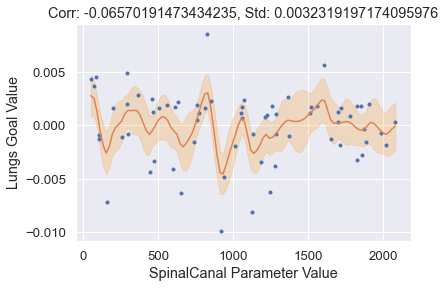

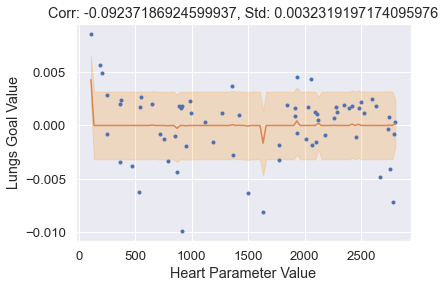

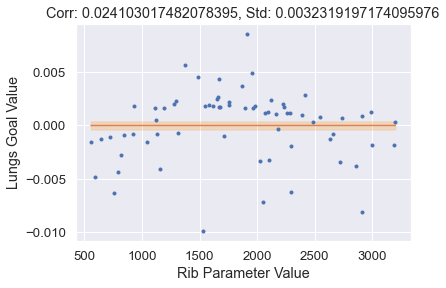

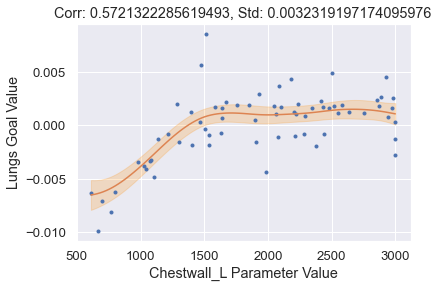

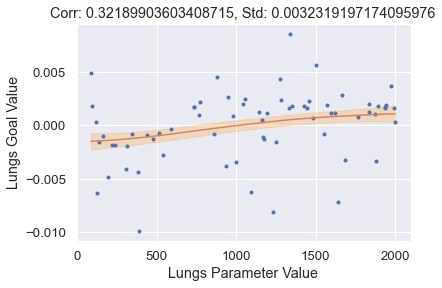

In [175]:
plot1('Lungs', 1, 1e-5) # 1e-3 to 1e-5

# SpinalCanal Goal 1

At most 2080 cGy dose at 0.35 cm$^3$ volume

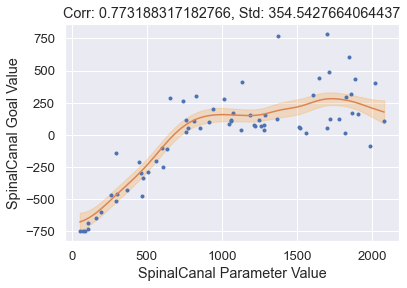

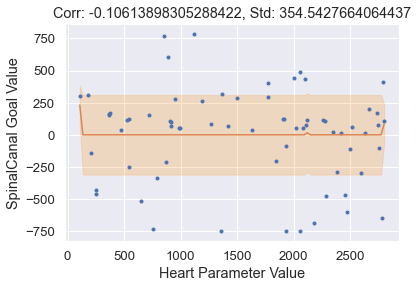

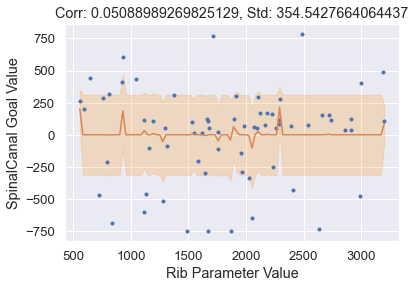

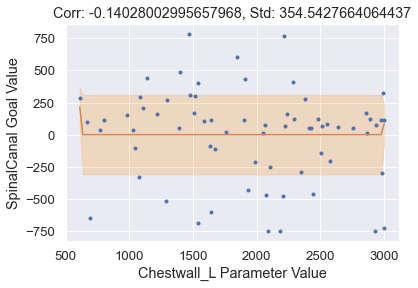

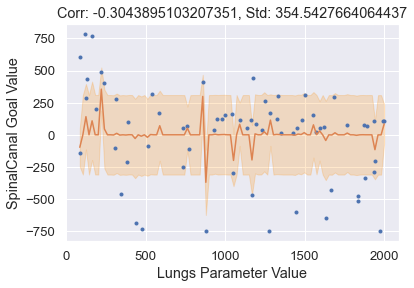

In [200]:
plot1('SpinalCanal', 0, 3e4) #

# Rib Goal 1

At most 1 cm$^3$ volume at 3200 cGy dose

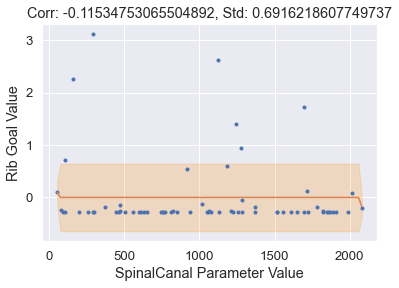

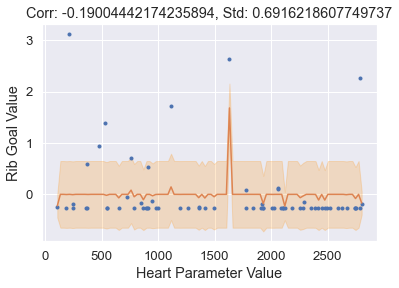

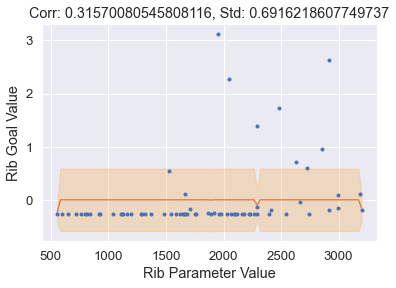

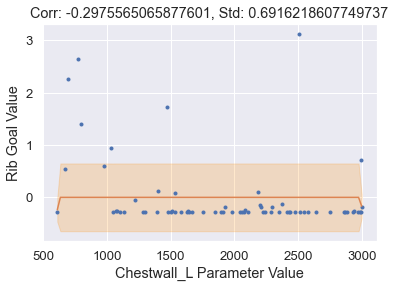

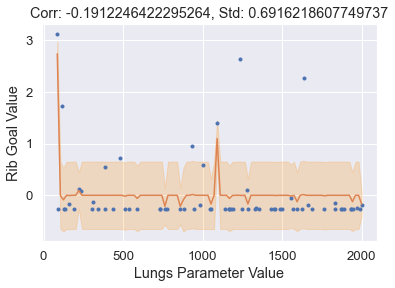

In [207]:
plot1('Rib', 0, 6e-2) # no idea

# Rib Goal 2

At most 4000 cGy dose at 0.04 cm$^3$ volume

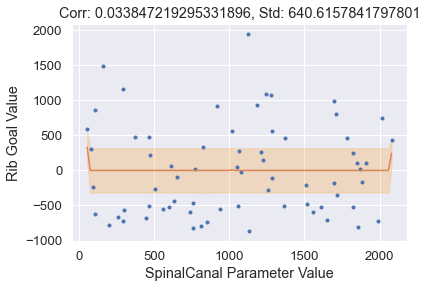

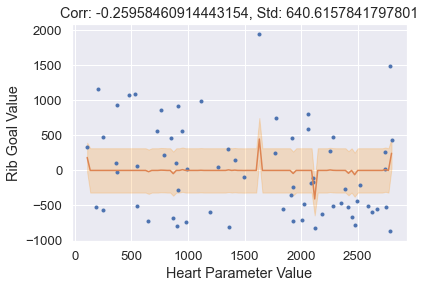

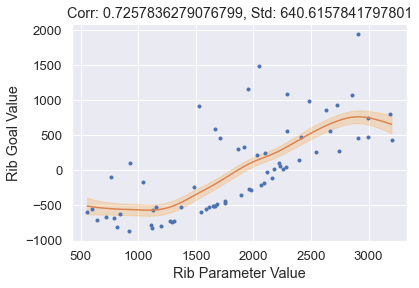

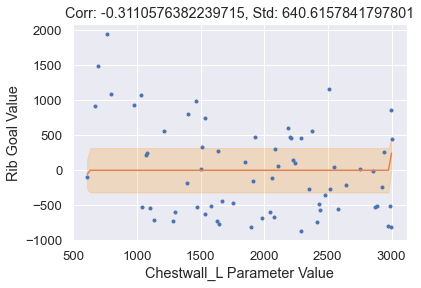

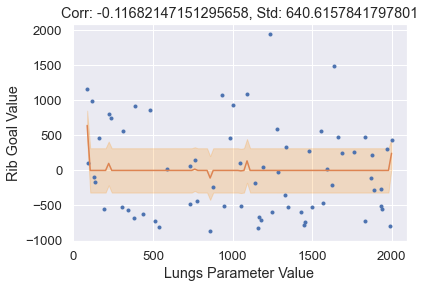

In [216]:
plot1('Rib', 1, 8e4) # maybe process not Gaussian, but other distribution

# Chestwall_L Goal 1

At most 30 cm$^3$ volume at 3000 cGy dose

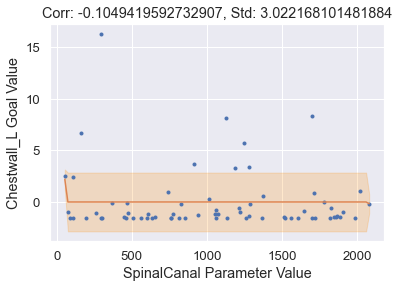

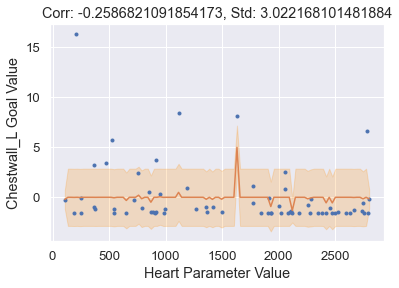

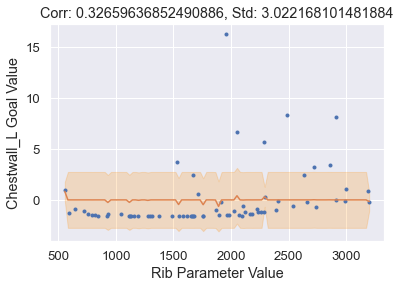

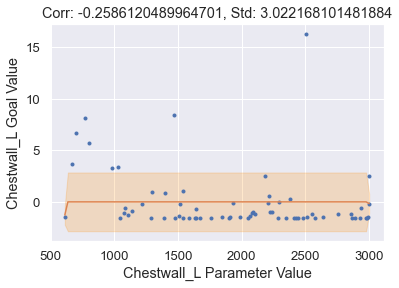

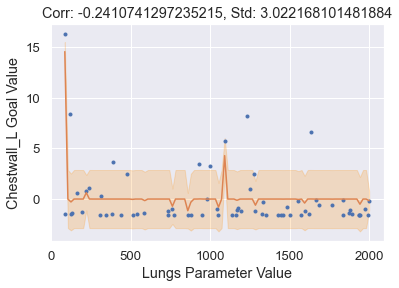

In [218]:
plot1('Chestwall_L', 0, 1e0)

# PTV Goal 1

At least 95 % volume at 4800 cGy dose

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:504: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0.

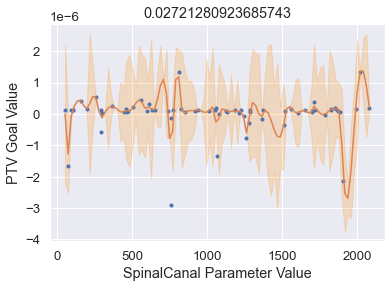

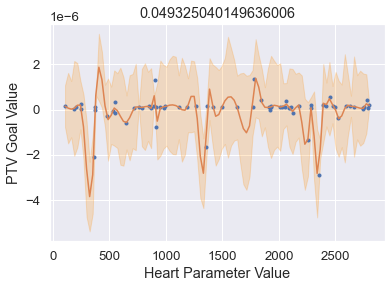

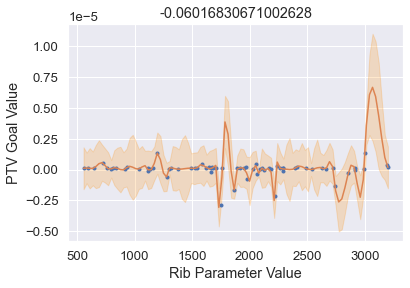

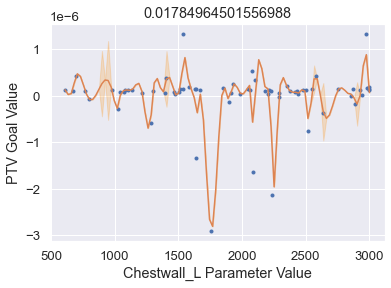

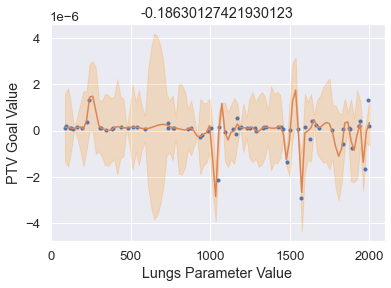

In [129]:
plot1('PTV', 0)

# PTV Goal 2

At least 99 % volume at 4320 cGy dose

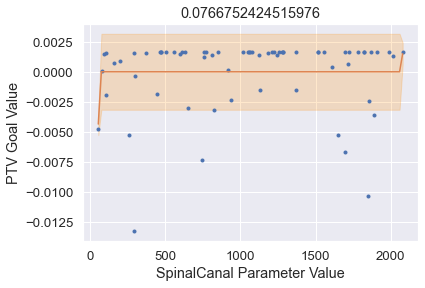

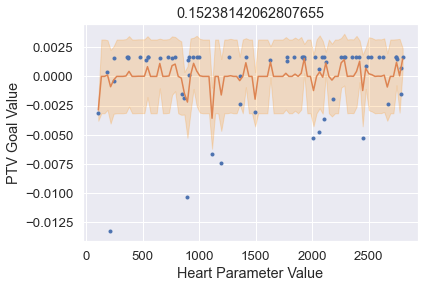

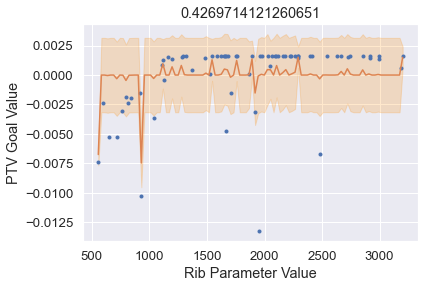

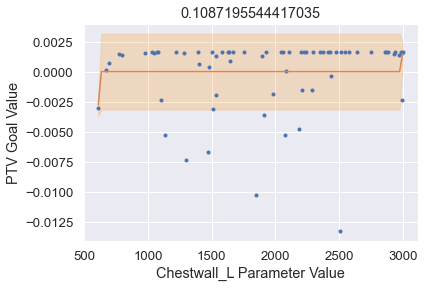

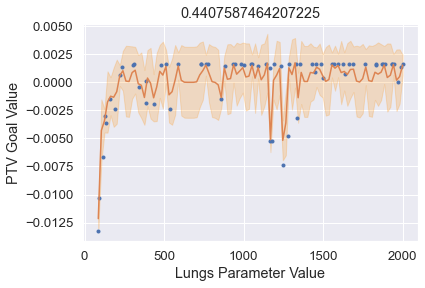

In [130]:
plot1('PTV', 1)

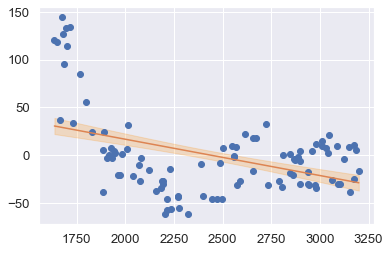

In [2]:
chest = np.array(utils.roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
lung = np.array(utils.roi_stats(samples, 'PTV', 'Max'))

gpr = GaussianProcessRegressor(kernel=kernels.DotProduct(), alpha=np.var(lung)).fit(chest, lung-np.mean(lung))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(chest, lung-np.mean(lung), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

Text(0, 0.5, 'Rib Goal 2')

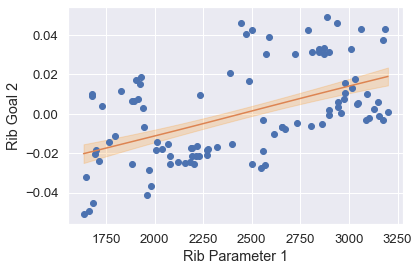

In [3]:
x = np.array(utils.roi_pars(samples, 'Rib')[0]).reshape(-1, 1)
y = np.array(utils.roi_goals(samples, 'SpinalCanal')[0])

gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=np.var(y)).fit(x, y - np.mean(y))

x_vals = np.linspace(min(chest), max(chest), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

plt.plot(x, y - np.mean(y), 'o')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)
plt.xlabel('Rib Parameter 1')
plt.ylabel('Rib Goal 2')

In [ ]:
# Was going to make a function to interpolate data (or predict with GP),
# Then see how the function varies with it...

# Guessing that the Rib parameter is really the most important here,
# is that still true with the function values?

# Could also plot function vs. parameter value (though it would be a projection since five parameters...)

Text(0, 0.5, 'Lungs Average')

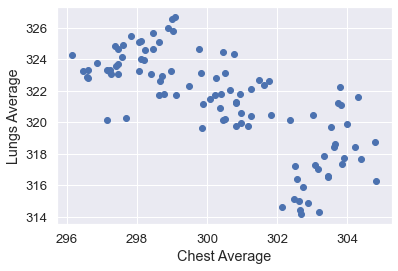

In [4]:
stat = 'Average'
plt.plot(utils.roi_stats(samples, 'Chestwall_L', stat), utils.roi_stats(samples, 'Lungs', stat), 'o')
plt.xlabel(f'Chest {stat}')
plt.ylabel(f'Lungs {stat}')

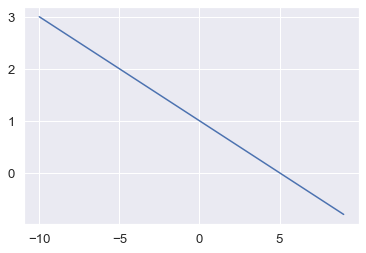

In [420]:
# What if we just started with the value with the highest correlation?

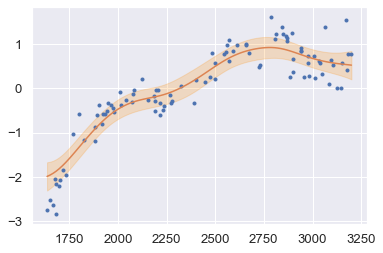

In [668]:
roi = 'Heart'
term = 0
oar = 'Rib'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e-0).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

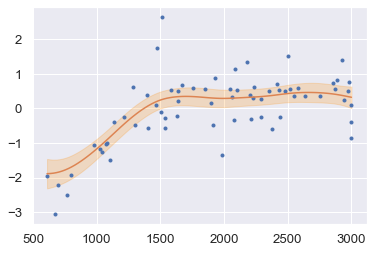

In [535]:
roi = 'Lungs'
term = 1
oar = 'Chestwall_L'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e0).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

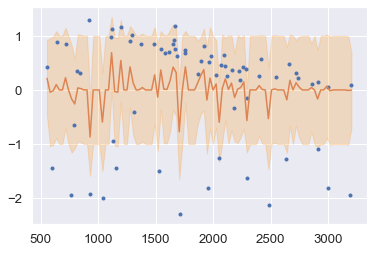

In [700]:
roi = 'Lungs' 
term = 0
oar = 'Rib'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

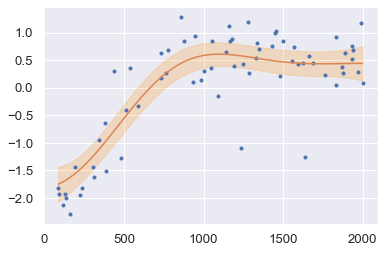

In [697]:
roi = 'Lungs'
term = 0
oar = 'Lungs'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.RBF(), alpha=1e0).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

In [672]:
roi = 'PTV'
term = 1
oar = 'Rib'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e-1).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

# Both the rib and the lungs have some outliers skewing the function

/Users/Kelsey/anaconda3/envs/autoray/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

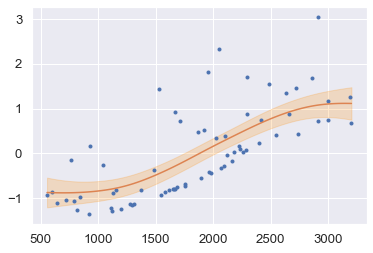

In [643]:
roi = 'Rib'
term = 1
oar = 'Rib'

# Data
roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term])
oar_list = np.array(par_list[oar])
x = oar_list.reshape(-1, 1)
y = (roi_list - np.mean(roi_list))/np.std(roi_list)

# Estimate
gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=1e0).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

# here it looks like a Gaussian isn't the best distribution to estimate the values...

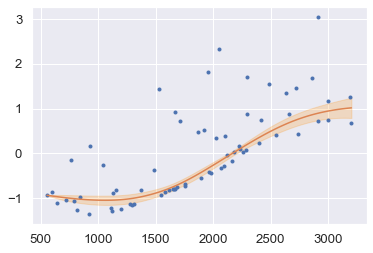

In [660]:
# Estimate

y_est = gpr.predict(x)
alpha = np.abs(y - y_est)

gpr = GaussianProcessRegressor(kernel=kernels.Matern(), alpha=alpha).fit(x, y)
x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
y_mean, y_std = gpr.predict(x_vals, return_std=True)

# Plot
plt.plot(x, y, '.')
plt.plot(x_vals, y_mean)
plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)

# Both the rib and the lungs have some outliers skewing the function

In [645]:
y.shapev

AttributeError: 'numpy.ndarray' object has no attribute 'shapev'

In [ ]:
def plot1(roi, term, alpha=None):
    roi_list = np.array(utils.roi_goals(samples, roi, percent=False)[term]);
    for oar in oar_list:
        plot2(np.array(par_list[oar]), np.array(roi_list), oar, roi, alpha)
        
def plot2(par_list, roi_list, oar, roi, alpha):
    # Plot data
    plt.figure()
    plt.plot(par_list, roi_list - np.mean(roi_list), '.')
    
#     # Estimate function
#     x = par_list.reshape(-1, 1)
#     y = roi_list - np.mean(roi_list)
#     gpr = GaussianProcessRegressor(kernel=1.0*kernels.Matern(), alpha=alpha).fit(x, y)
    
#     # Estimate values
#     x_vals = np.linspace(min(x), max(x), 100).reshape(-1, 1)
#     y_mean, y_std =gpr.predict(x_vals, return_std=True)
    
#     # Plot values
#     plt.plot(x_vals, y_mean)
#     plt.fill_between(x_vals.squeeze(), y_mean - y_std, y_mean + y_std, color='darkorange', alpha=0.2)
    
    # Add labels
    plt.xlabel(f'{oar} Parameter Value')
    plt.ylabel(f'{roi} Goal Value')
    plt.title(f'Corr: {np.corrcoef(par_list, roi_list)[0, 1]}, Std: {np.std(y)}')

In [ ]:
# We could hold all variables constant, and then see how each goal changes with respect to each 
# of the parameters individually (expensive)

# My issue is the values that seem noisy. Maybe they are on the lower range of somebody's values,
# but I don't know which one.

# If I looked at the old dataset, maybe this wouldn't be a problem?